In [1]:
# Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import urllib
import requests
from bs4 import BeautifulSoup
import re
import networkx as nx
from tqdm import tqdm
from time import time

In [2]:
# example data from wiki
w = pd.read_csv("pageviews-20151012-20180429.csv")

In [72]:
len(w["Influenza"])/7

133.0

In [79]:
sum(w["Influenza"][-14:])-1061

1318

In [82]:
wiki_inf = pd.DataFrame()
click_sum = 0
week_counter = 0
i = 0
while i < len(w)-6:
    for j in range(i, i+6):
        click_sum += w["Influenza"][j]
    week_counter += 1
    wiki_inf = wiki_inf.append({"Date": w["Date"][i][0:4] + " - " + str(week_counter), "Influenza": click_sum}, ignore_index=True)
    click_sum = 0
    i += 6

In [83]:
wiki_inf

,Date,Influenza
0,2015 - 1,1244.0
1,2015 - 2,1142.0
2,2015 - 3,1106.0
3,2015 - 4,1015.0
4,2015 - 5,1214.0
5,2015 - 6,1065.0
6,2015 - 7,1088.0
7,2015 - 8,1294.0
8,2015 - 9,1267.0
9,2015 - 10,1277.0


In [38]:
# Take the csv files from influnet folder clean the dataframes and return a dataframe containing the ground truth
# the gt dataframe has two columns: the week and the incidence value

files = glob.glob("influnet/*")
temp_gt = []
for file in files:
    print("Adding file " + file + " ...")
    temp = pd.read_csv(file, header=None)
    temp = temp[[0,4]]
    temp = temp.drop(temp.index[0:3])
    temp = temp.replace(to_replace=",", value=".", regex=True)
    temp[4] = pd.to_numeric(temp[4])
    temp = temp.reset_index(drop=True)
    temp.columns=["Date","Influenza"]
    temp_gt.append(temp)

gt = pd.concat(temp_gt, axis=0, ignore_index=True)

Adding file influnet\tabula-InfluNet - Stagione 2015 - 2016.csv ...
Adding file influnet\tabula-InfluNet - Stagione 2016 - 2017.csv ...
Adding file influnet\tabula-InfluNet - Stagione 2017 - 2018.csv ...


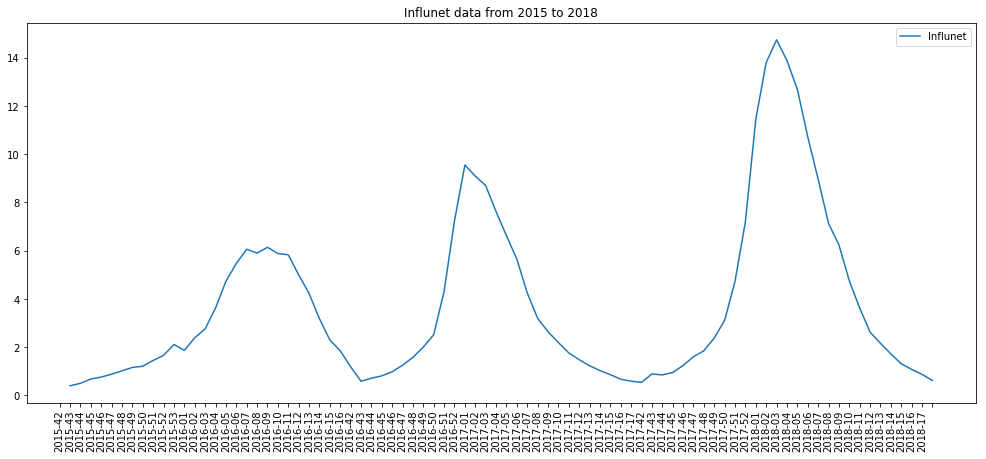

In [96]:
# Plot influnet data

gt.plot(y = "Incidence", label = "Influnet", figsize=(17,7))
plt.xticks(np.arange(-1, len(gt["Incidence"])), gt["Week"], rotation=90)
plt.title("Influnet data from 2015 to 2018")
plt.show()
plt.close()

## Part 2

In [7]:
url = "https://it.wikipedia.org/wiki/Influenza"

In [13]:
def get_wiki_links(url):
    '''This function takes the out links of a page given in url.
        /wiki is the starting tag of wikipedia pages
        PMID is the tag for counting the citations in a page (we are not interested about it)'''
    page_response = requests.get(url)
    soup = BeautifulSoup(page_response.content, "html.parser")
    links = []
    for link in soup.find_all('a'):
        temp = str(link.get('href'))
        if temp[0:5] == "/wiki" and "PMID" not in temp and ":" not in temp and "secolo" not in temp:
            try:
                int(temp[-4:])
            except:
                links.append("https://it.wikipedia.org" + temp)
    return links

In [14]:
wiki_links = get_wiki_links(url)
wiki_links

['https://it.wikipedia.org/wiki/Microscopio',
 'https://it.wikipedia.org/wiki/Medicina_generale',
 'https://it.wikipedia.org/wiki/Pneumologia',
 'https://it.wikipedia.org/wiki/Malattia_infettiva',
 'https://it.wikipedia.org/wiki/Medical_Subject_Headings',
 'https://it.wikipedia.org/wiki/MedlinePlus',
 'https://it.wikipedia.org/wiki/EMedicine',
 'https://it.wikipedia.org/wiki/Malattia_infettiva',
 'https://it.wikipedia.org/wiki/Virus_a_RNA',
 'https://it.wikipedia.org/wiki/Orthomyxoviridae',
 'https://it.wikipedia.org/wiki/Febbre',
 'https://it.wikipedia.org/wiki/Rinorrea',
 'https://it.wikipedia.org/wiki/Mialgia',
 'https://it.wikipedia.org/wiki/Artralgia',
 'https://it.wikipedia.org/wiki/Cefalea',
 'https://it.wikipedia.org/wiki/Tosse',
 'https://it.wikipedia.org/wiki/Nausea',
 'https://it.wikipedia.org/wiki/Vomito',
 'https://it.wikipedia.org/wiki/Gastroenterite',
 'https://it.wikipedia.org/wiki/Polmonite',
 'https://it.wikipedia.org/wiki/Asma',
 'https://it.wikipedia.org/wiki/Scompe

In [15]:
len(wiki_links)

292

In [16]:
G = nx.Graph()
G.add_node(0)

In [21]:
# questo fa schifo come codice ma fa scraping delle pagine fino a hop_dist = 2

diz = {}
diz[0] = url
start = time()
for i in range(len(wiki_links)):
    G.add_node(i)
    diz[i+1] = wiki_links[i]
    G.add_node(i, size=50)
    G.add_edge(i, 0)
    links_h1 = get_wiki_links(wiki_links[i])
    for j in range(len(links_h1)):
        diz[i+j] = links_h1[j]
        G.add_node(j)
        G.add_edge(j, i)
end = time()
print(end-start)

132.81985306739807


In [22]:
# number of pages scraped
len(diz)

3237

In [ ]:
import heapq 

# Initialize graph 
G = nx.DiGraph()
G.add_node(0)
url = "https://it.wikipedia.org/wiki/Influenza"
label_url_map = dict()
label_url_map[0] = url


# visits all the nodes of a graph (connected component) using BFS
def d_neighborhood(G = G, start = 0, d = 2, label_url_map = label_url_map ):
    # keep track of all visited nodes
    explored = set()
    queue = [start]
    # keep track of nodes to be checked
    heapq.heapify(queue)
    current_label = 0
    distance = 0 

    
    # keep looping until there are nodes still to be checked
    while queue:

        # pop shallowest node (first node) from queue
        node = queue.pop()

        # condition for stopping 
        if nx.has_path(G, source = 0, target = node):
            distance = int(nx.shortest_path_length(G, source = 0, target = node))
            if distance > d: 
                return [G, label_url_map]
        
        if node not in explored:
            explored.add(node) 
            
            # nodes at distance 1 from the currently visited ones
            links = get_wiki_links(label_url_map[node])
            next_shell = [(current_label + i) for i in range(len(links))]
            for item in next_shell: 
                heapq.heappush(queue, item) 
            label_url_map.update({(current_label + i) : links[i] for i in range(len(links))})
            # update graph 
            G.add_nodes_from(next_shell) 
            G.add_edges_from([(current_label, current_label + 1 ) for i in range(len(links))])
            # update current label 
            current_label += len(next_shell) + 1 

In [ ]:
# Run bfs and store results 
bfs = d_neighborhood(G = G, start = 0, d = 2, label_url_map = label_url_map )
G = bfs[0]
urls = bfs[1] 

In [ ]:

# add inlinks 
def add_inLinks( G, label_url_map ):
    '''add 
    in-links to graph G '''
    
    # invert dictionary for efficiency 
    label_url_map_inverse = {v:k, for k,v in label_url_map.items()}
    
    for node in label_url_map: 
        page_response = requests.get(label_url_map[node]) 
        soup = BeautifulSoup(page_response.content, "html.parser")
        for link in soup.find_all('a'):
            temp = str(link.get('href'))
            if temp[0:5] == "/wiki" and "PMID" not in temp:
                # search for the link in the existing graph 
                if link in label_url_map.values(): 
                    # add directed edge 
                    G.add_edge( node , label_url_map_inverse[link]   ) 
                    
    return G

In [ ]:
#### Some node ranking approaches 

# link analysis 

# hits 
hitsRanking = nx.hits(G) 
# pagerank 
pageRanking = nx.pagerank(G)
# personalized with sure jump to influenza ? 
PersonalizedpageRanking = nx.pagerank(G,personalization={0:1})

# Others 

# degree
degrees = G.degrees() 

# coreness 
coreness = nx.core_number(G) 

# Influenza-based : e.g. number of paths to influenza 

n_paths = []
for node in G.nodes: 
    n_paths.append(len(all_simple_paths(G, source = 0, target = node)))

n_pathRanking = sorted(n_paths) 

# Just take nodes connected to influneza (in-links / out-links)

# Enough bullshits for today